In [2]:
# NLP Job classifier - based on "IT job classifier on Armenian data, Kaggle" 

In [4]:
# This version, last modified 
# Nov 21st 2022
# Sila

In [5]:
import numpy as np
import pandas as pd

#for charts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud      #need to install wordcloud package

In [6]:
#for text processing
import string
import re
import nltk
from textblob import TextBlob

In [7]:
#for tokenization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#for feature selection
from sklearn import decomposition

#for model building
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [9]:
from google.colab import files
uploaded = files.upload()

Saving datajobposts.csv to datajobposts.csv


### Import data

In [10]:
# The file datajobposts is 95 MB, took 2 min to upload to colab...
!ls

datajobposts.csv  sample_data


In [11]:
jobs = pd.read_csv('datajobposts.csv')

In [12]:
jobs.head().T

,0,1,2,3,4
jobpost,AMERIA Investment Consulting Company\r\nJOB TI...,International Research & Exchanges Board (IREX...,Caucasus Environmental NGO Network (CENN)\r\nJ...,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,Yerevan Brandy Company\r\nJOB TITLE: Software...
date,"Jan 5, 2004","Jan 7, 2004","Jan 7, 2004","Jan 7, 2004","Jan 10, 2004"
Title,Chief Financial Officer,Full-time Community Connections Intern (paid i...,Country Coordinator,BCC Specialist,Software Developer
Company,AMERIA Investment Consulting Company,International Research & Exchanges Board (IREX),Caucasus Environmental NGO Network (CENN),Manoff Group,Yerevan Brandy Company
AnnouncementCode,NaN,NaN,NaN,NaN,NaN
Term,NaN,NaN,NaN,NaN,NaN
Eligibility,NaN,NaN,NaN,NaN,NaN
Audience,NaN,NaN,NaN,NaN,NaN
StartDate,NaN,NaN,NaN,NaN,NaN
Duration,NaN,3 months,Renewable annual contract\r\nPOSITION,NaN,NaN


In [13]:
jobs.shape

(19001, 24)

In [14]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

In [15]:
#lowercase the column names
jobs.columns = jobs.columns.str.lower()

In [16]:
jobs.columns

Index(['jobpost', 'date', 'title', 'company', 'announcementcode', 'term',
       'eligibility', 'audience', 'startdate', 'duration', 'location',
       'jobdescription', 'jobrequirment', 'requiredqual', 'salary',
       'applicationp', 'openingdate', 'deadline', 'notes', 'aboutc', 'attach',
       'year', 'month', 'it'],
      dtype='object')

# Data Cleaning

In [17]:
#removing duplicate jobposts based on title and post
jobs = jobs.drop_duplicates(['jobpost', 'title'])

In [18]:
jobs.shape

(18892, 24)

In [19]:
#removing records with null title
#jobs = jobs[jobs.title.notna()]
#jobs.shape

# Type of demanding jobs in Armenia

**1. Preprocessing the text data**

In [20]:
jobs['title'] = jobs['title'].astype('str')

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
#UDF to do basic cleaning of title column to understand type of jobs
def clean_data(text):
    text = text.lower()  # convert all the text into lowercase
    text = text.strip()  #remove starting and trailing whitespaces
    #special_chars = re.compile('[@!#$%^&*()<>?/\|}{~:;]')
    #text = re.sub(special_chars,'', text)
    special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
    text = re.sub(special_char_reg, ' ', text)
    text = re.sub(r'\s+', ' ', text) #remove all line formattings
    text = re.sub(r'\d+', '', text) #remove digits
    text = ''.join(c for c in text if c not in string.punctuation)   #remove pecial symbols from job titles
    return text

In [23]:
a = 'Ful8l-ti9me Community Connections f09:053yy'
special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
re.sub(special_char_reg, ' ', a).strip()

'Community Connections'

In [24]:
jobs.title.head(6)

0                              Chief Financial Officer
1    Full-time Community Connections Intern (paid i...
2                                  Country Coordinator
3                                       BCC Specialist
4                                   Software Developer
5                                           Saleswoman
Name: title, dtype: object

In [25]:
title_df = jobs.title.apply(lambda x : clean_data(x))
title_df.head()

0                          chief financial officer
1     community connections intern paid internship
2                              country coordinator
3                                   bcc specialist
4                               software developer
Name: title, dtype: object

In [26]:
from nltk import WordNetLemmatizer
#nltk.download('punkt')

In [27]:
#nltk.download('wordnet')

In [28]:
def lemma(text):
    word_list = nltk.word_tokenize(text) #tokenize beofre lemmatization
    lemma_output = ' '.join(WordNetLemmatizer().lemmatize(word) for word in word_list)
    return lemma_output

In [30]:
##Lematization
import spacy
#neccesary to download the english model using "python -m spacy download en"
nlp = spacy.load('en_core_web_sm')
# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])

'the stripe bat be hang on their foot for good'

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [36]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [37]:
title_df_1 = title_df.apply(lambda x : lemma(x))

In [38]:
title_df_1.head()

0                        chief financial officer
1    community connection intern paid internship
2                            country coordinator
3                                 bcc specialist
4                             software developer
Name: title, dtype: object

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
#Stop words removal
stop = nltk.corpus.stopwords.words('english')
#stop.extend(['armenian', 'armenia', 'job', 'title', 'position', 'location', 'responsibilities', 'application',
#                  'procedures', 'deadline', 'required','qualifications', 'renumeration', 'salary', 'date', 'company', 'llc'])

In [42]:
title_df_1 = title_df_1.apply(lambda x : ' '.join(x for x in x.split() if x not in stop))

In [43]:
title_df_1.head()

0                        chief financial officer
1    community connection intern paid internship
2                            country coordinator
3                                 bcc specialist
4                             software developer
Name: title, dtype: object

Now to undertand the most demanding jobs in armenia we can create a **bi/tri gram DTM** on the job titles and find the most occuring token to be the most demanding job

In [44]:
#Tokenization using count vectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
token = count_vect.fit_transform(title_df_1)

In [45]:
token

<18892x2542 sparse matrix of type '<class 'numpy.int64'>'
	with 53675 stored elements in Compressed Sparse Row format>

In [46]:
print(count_vect.get_feature_names())

['aacas', 'abap', 'abatement', 'abattoir', 'abkhazia', 'abovyan', 'abuse', 'academy', 'acca', 'access', 'accident', 'account', 'accountability', 'accountancy', 'accountant', 'accounting', 'achajour', 'acquiring', 'acquisition', 'act', 'action', 'actionscript', 'activation', 'active', 'activity', 'actuarial', 'actuary', 'ad', 'adaptation', 'adb', 'added', 'addition', 'address', 'adherence', 'adjuster', 'adjustor', 'admin', 'administration', 'administrative', 'administrator', 'adminsitrative', 'adminstration', 'adminstrative', 'adminstrator', 'admission', 'adobe', 'adolescent', 'adp', 'advanced', 'adventure', 'advertisement', 'advertising', 'advertizing', 'adviser', 'advising', 'advisor', 'advisory', 'advocacy', 'advocate', 'aerobics', 'affair', 'affiliate', 'affluent', 'agency', 'agent', 'agile', 'agreement', 'agribusiness', 'agricultural', 'agriculture', 'agriculturist', 'agro', 'agronomist', 'agroprocessing', 'aid', 'aide', 'aided', 'aiming', 'air', 'aircraft', 'airline', 'airport', '

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
print('Total number of tokens/words in all the job titles - ', len(count_vect.get_feature_names()))

Total number of tokens/words in all the job titles -  2542


In [48]:
temp_df =  pd.DataFrame(token.toarray(), columns=count_vect.get_feature_names())
temp_df.tail()

,aacas,abap,abatement,abattoir,abkhazia,abovyan,abuse,academy,acca,access,...,yield,yoga,young,youth,zang,zend,zonal,zone,zooplankton,zvartnots
18887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#count the accurence of each token in entire corpus
count_df = temp_df.apply(lambda x : x.sum())

In [50]:
count_df = pd.DataFrame(count_df).reset_index()

In [51]:
count_df.columns = ['Word', 'Count']

In [52]:
top_jobs = count_df.sort_values(by= 'Count', ascending=False)

In [53]:
top_jobs[:10]

,Word,Count
1382,manager,2587
2134,specialist,2067
661,developer,1942
797,engineer,1601
2053,senior,1490
179,assistant,1234
2115,software,1099
2003,sale,855
14,accountant,779
649,department,742


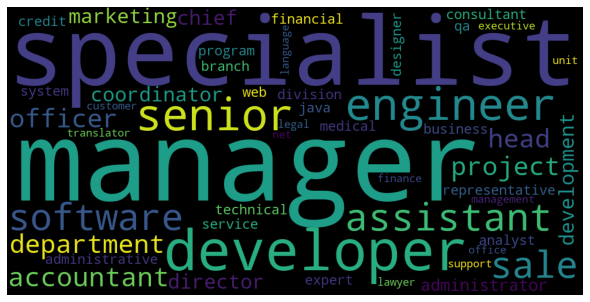

In [54]:
# plot the WordCloud image to show top 50 type of demanding jobs in armenia     
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(top_jobs[:50].Word))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# IT Job Classification

In [55]:
class_data = jobs[(jobs.title.isna() == False) & (jobs.jobrequirment.isna() == False) & (jobs.requiredqual.isna() == False) &
                 (jobs.jobdescription.isna() == False) & (jobs.aboutc.isna() == False) & (jobs.company.isna() == False)]

In [56]:
class_data.shape

(8993, 24)

In [57]:
class_data.isna().sum()

jobpost                0
date                   0
title                  0
company                0
announcementcode    8379
term                4359
eligibility         6619
audience            8648
startdate           3830
duration            2860
location               1
jobdescription         0
jobrequirment          0
requiredqual           0
salary              3549
applicationp           0
openingdate          125
deadline               4
notes               8036
aboutc                 0
attach              8528
year                   0
month                  0
it                     0
dtype: int64

In [58]:
#identify Y variable
class_data['it'] = class_data.it.apply(lambda x : 0 if (x is False) else 1)
y=class_data['it']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
y.value_counts()

0    6780
1    2213
Name: it, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


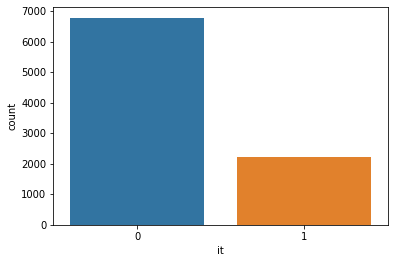

In [60]:
sns.countplot(y)

In [61]:
class_data = class_data['title'].str.cat(class_data['jobrequirment'], sep =" ").str.cat(class_data['requiredqual'], sep =" ").str.cat(
    class_data['jobdescription'], sep =" ").str.cat(class_data['aboutc'], sep =" ").str.cat(class_data['company'], sep =" ")
class_df = class_data

In [62]:
class_df.head()

2     Country Coordinator - Working with the Country...
22    Marketing Advisor - Lead the effort to identif...
56    Manufacturing Chief - To manage all manufactur...
64    Administrative Assistant/ Secretary - To welco...
67    Salesman / Trade agent - To distribute and dis...
Name: title, dtype: object

### Text pre-processing

In [63]:
class_df = class_df.apply(lambda x : clean_data(str(x)))
class_df.head()

2     country coordinator  working with the country ...
22    marketing advisor  lead the effort to identify...
56    manufacturing chief  to manage all manufacturi...
64    administrative assistant secretary  to welcome...
67    salesman  trade agent  to distribute and displ...
Name: title, dtype: object

In [64]:
#Lemmatization
class_df_1 = class_df.apply(lambda x : lemma(x))

In [65]:
class_df_1.head()

2     country coordinator working with the country d...
22    marketing advisor lead the effort to identify ...
56    manufacturing chief to manage all manufacturin...
64    administrative assistant secretary to welcome ...
67    salesman trade agent to distribute and display...
Name: title, dtype: object

In [66]:
#stop word removal
class_df_1 = class_df_1.apply(lambda x : ' '.join(x for x in x.split() if x not in stop))

In [67]:
class_df_1.head()

2     country coordinator working country director p...
22    marketing advisor lead effort identify target ...
56    manufacturing chief manage manufacturing funct...
64    administrative assistant secretary welcome vis...
67    salesman trade agent distribute display import...
Name: title, dtype: object

In [68]:
#Tokenization
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), min_df = 0.05, max_df=0.95, stop_words='english')
x_tdm = tfidf_vect.fit_transform(class_df_1)
#print(x_tdm)

In [69]:
df_clust = pd.DataFrame(x_tdm.toarray(), columns=tfidf_vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
df_clust.head()

,ability,access,accordance,according,account,accountant,accounting,accuracy,accurate,achieve,...,window,word,work,working,world,write,writing,written,year,yerevan
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.117356,0.0,0.0,0.0,0.059906,0.038047,0.000000
1,0.014893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.038855,0.031132,0.012671,0.000000,0.0,0.0,0.0,0.000000,0.043375,0.000000
2,0.032816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.111679,0.000000,0.0,0.0,0.0,0.050161,0.031857,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.122111,0.000000,0.000000,0.0,0.0,0.0,0.089294,0.056711,0.116185
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293523,...,0.000000,0.000000,0.000000,0.158408,0.0,0.0,0.0,0.000000,0.205424,0.000000


## Building a Random Forest Model

#### Divide the data into train and test

In [71]:
df_clust.shape

(8993, 505)

In [72]:
from sklearn.model_selection import train_test_split

train_x, test_x,train_y, test_y = train_test_split(df_clust,y, test_size = 0.2, random_state = 5)
print(train_x.shape, test_x.shape)

(7194, 505) (1799, 505)


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [74]:
param_grid = {'n_estimators':[130,150,160,180,200],
              'max_features':[13,15,17,19]}

grid_rf = GridSearchCV(estimator= RandomForestClassifier(),
                      param_grid=param_grid,
                      cv = 10,
                      n_jobs=-1, verbose=True)

grid_rf.fit(train_x,train_y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [13, 15, 17, 19],
                         'n_estimators': [130, 150, 160, 180, 200]},
             verbose=True)

In [75]:
grid_rf.best_score_

0.949676827383712

In [76]:
grid_rf.best_params_

{'max_features': 13, 'n_estimators': 150}

In [77]:
grid_rf.best_estimator_

RandomForestClassifier(max_features=13, n_estimators=150)

In [78]:
#Fit the model
rf_model = grid_rf.best_estimator_
rf_model.fit(train_x, train_y)

RandomForestClassifier(max_features=13, n_estimators=150)

#### Predict the output for train and validation set

In [79]:
rf_train_predict = pd.DataFrame({'actual' : train_y,
                                 'predicted' : rf_model.predict(train_x)})
rf_train_predict.head()

,actual,predicted
18595,1,1
14290,1,1
12772,1,1
13946,0,0
9745,0,0


In [80]:
rf_test_predict = pd.DataFrame({'actual' : test_y,
                                 'predicted' : rf_model.predict(test_x)})
rf_test_predict.head()

,actual,predicted
8007,0,0
6159,0,0
9782,0,0
6132,0,0
6649,0,0


# Model Evaluation

In [81]:
#1. Check accuracy score on train and test

print('Accuracy Score for train dataset : ' , metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted))
print('Accuracy Score for test dataset : ' , metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted))

Accuracy Score for train dataset :  0.9998609952738393
Accuracy Score for test dataset :  0.942745969983324


In [82]:
#2. Check roc_auc score on train and test

print('ROC-AUC Score for train dataset : ' , metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted))
print('ROC-AUC Score for validation dataset : ' , metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted))

ROC-AUC Score for train dataset :  0.9997209821428572
ROC-AUC Score for validation dataset :  0.9007667141266389


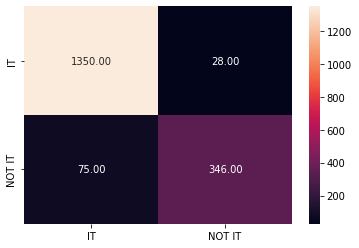

In [84]:
#3. Create confusion matrix
#for test

conn_cm_test = metrics.confusion_matrix(rf_test_predict.actual, rf_test_predict.predicted)
sns.heatmap(conn_cm_test, fmt= '.2f', annot=True,  xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT'])

In [85]:
#4. Create classification report
print(metrics.classification_report(rf_test_predict.actual, rf_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1378
           1       0.93      0.82      0.87       421

    accuracy                           0.94      1799
   macro avg       0.94      0.90      0.92      1799
weighted avg       0.94      0.94      0.94      1799



In [86]:
indices = np.argsort(rf_model.feature_importances_)[::-1]
feature_rank = pd.DataFrame(columns = ['rank', 'feature', 'importance'])
for f in range(train_x.shape[1]):
    feature_rank.loc[f] = [f+1,
                          train_x.columns[indices[f]],
                          rf_model.feature_importances_[indices[f]]]
feature_rank.round(3)

,rank,feature,importance
0,1,software,0.063
1,2,developer,0.059
2,3,application,0.036
3,4,design,0.021
4,5,sql,0.021
...,...,...,...
500,501,ngo,0.000
501,502,chief,0.000
502,503,coordinator,0.000
503,504,oversee,0.000


In [87]:
feature_rank[:17]

,rank,feature,importance
0,1,software,0.062674
1,2,developer,0.058501
2,3,application,0.036283
3,4,design,0.020606
4,5,sql,0.020530
5,6,development,0.020268
6,7,oop,0.019558
7,8,html,0.019416
8,9,experience,0.019327
9,10,java,0.019086


Presence of keywords like software, developer, web, design, cs are the important feautures while clasifying any job as **IT or NON-IT**